In [23]:
import os
# import h5py
from util.misc import saveraster
from j_output.user_output import TmrtOutput
from j_dataprep import DEMs

from collections import defaultdict
from j_dataprep.landcover import LandCover
from osgeo import gdal
from j_dataprep.DEMs import Buildings
import numpy as np

# for average heat day no trees

In [9]:
bbox_dict = {
        'historisch': [(175905, 317210, 176505, 317810), (84050, 447180, 84650, 447780), (80780, 454550, 81380, 455150),
                       (233400, 581500, 234000, 582100), (136600, 455850, 137200, 456450),
                       (121500, 487000, 122100, 487600)
                       ],
        'tuindorp': [(76800, 455000, 78200, 455700), (152600, 463250, 153900, 463800), (139140, 469570, 139860, 470400),
                     (190850, 441790, 191750, 442540), (113100, 551600, 113650, 552000), (32050, 391900, 32850, 392500)

                     ],
        'vinex': [(146100, 486500, 147000, 487400), (153750, 467550, 154650, 468450), (115300, 517400, 116100, 518250),
                  (102000, 475900, 103100, 476800), (160750, 388450, 161650, 389350), (84350, 449800, 85250, 450700)

                  ],
        'volkswijk': [(104200, 490550, 105100, 491450), (78200, 453900, 79100, 454800), (83500, 447020, 84050, 447900),
                      (136200, 456500, 137100, 457300), (182700, 579200, 183800, 579750),
                      (233400, 582800, 234300, 583700)

                      ],
        'bloemkool': [(81700, 427490, 82700, 428200), (84050, 444000, 84950, 444900), (116650, 518700, 117550, 519600),
                      (235050, 584950, 235950, 585850), (210500, 473900, 211400, 474800),
                      (154700, 381450, 155700, 382150)

                      ],

        'stedelijk': [
            (90300, 436900, 91300, 437600), (91200, 438500, 92100, 439300), (121350, 483750, 122250, 484650),
            (118400, 486400, 119340, 487100)
        ]
}

loaded


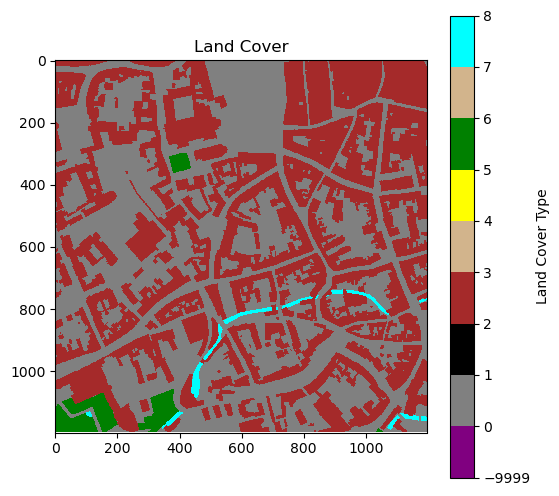

loaded


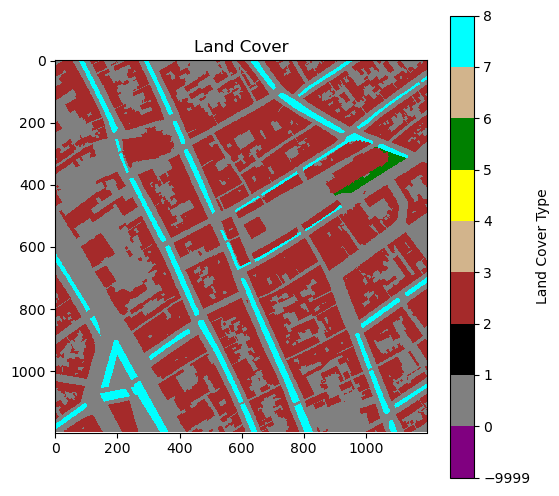

loaded


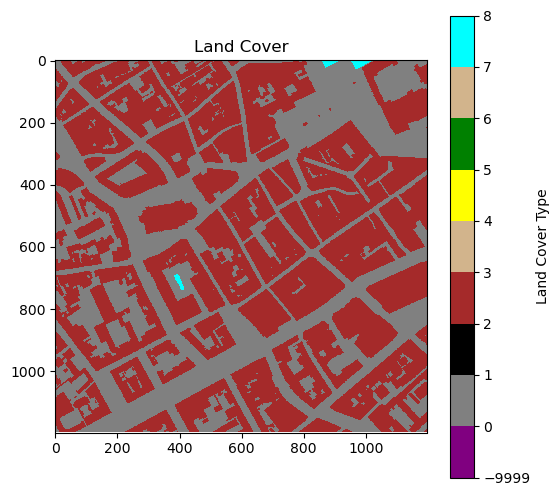

loaded
No valid water geometries found. Skipping water rasterization.


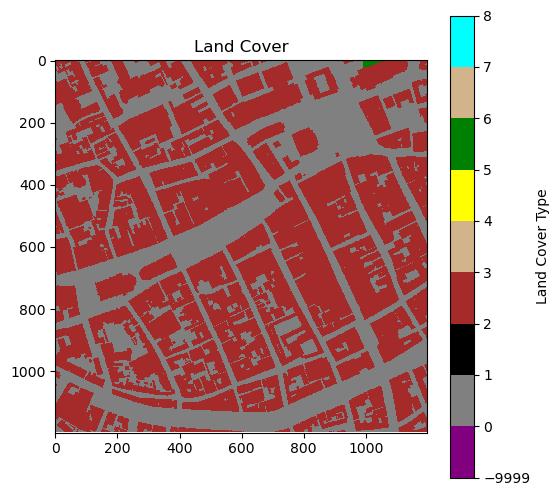

loaded


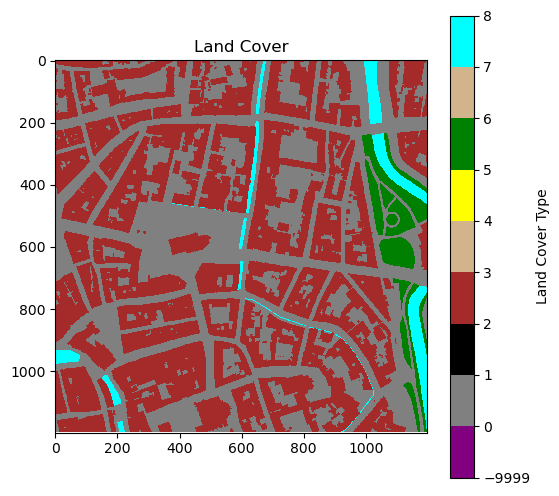

loaded


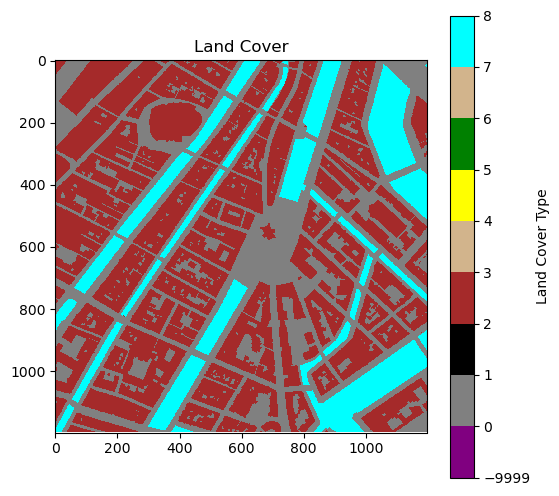

loaded


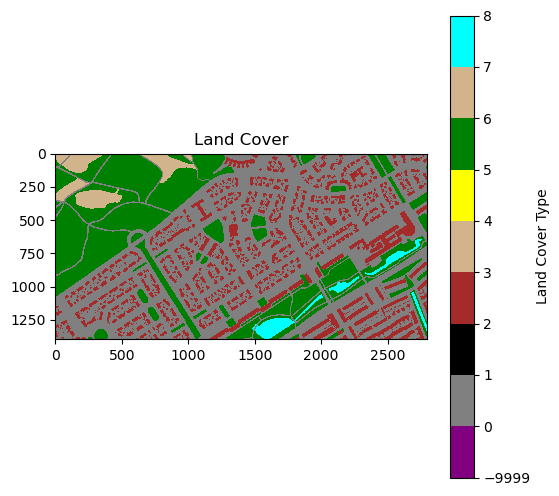

loaded


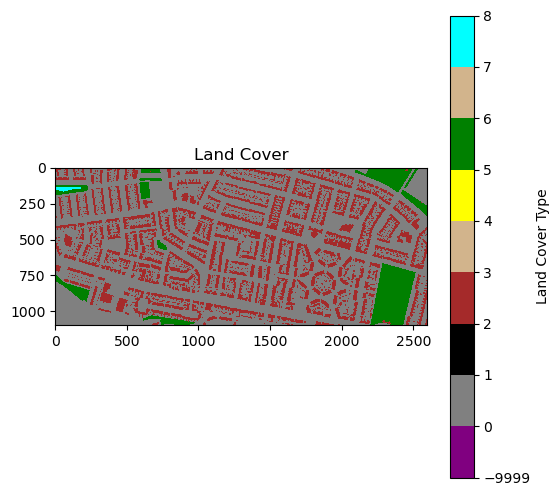

loaded


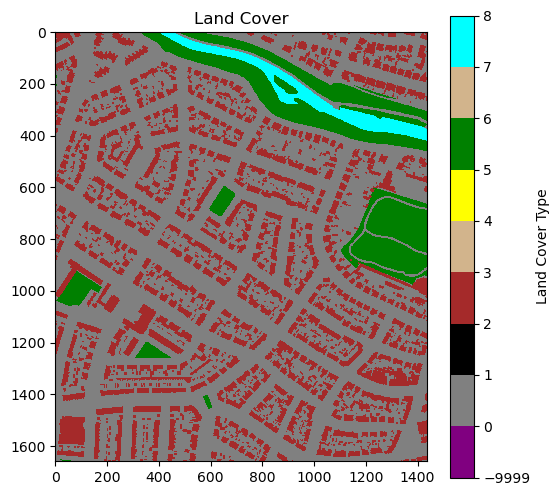

loaded


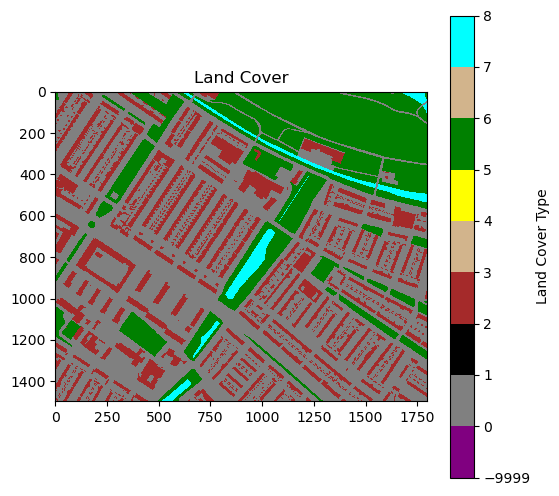

loaded


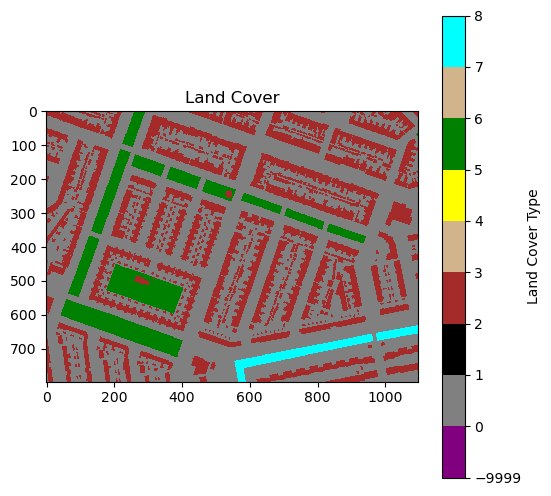

loaded


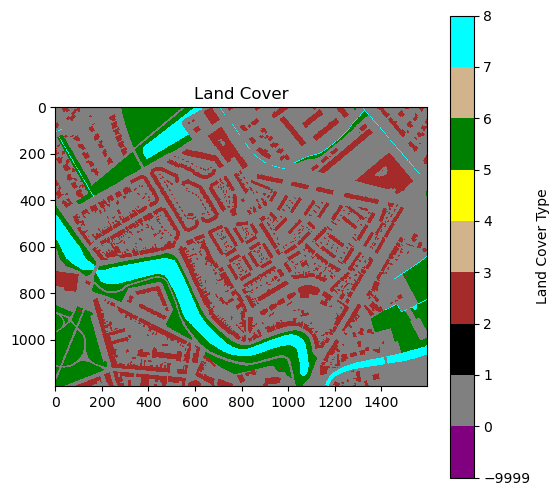

loaded


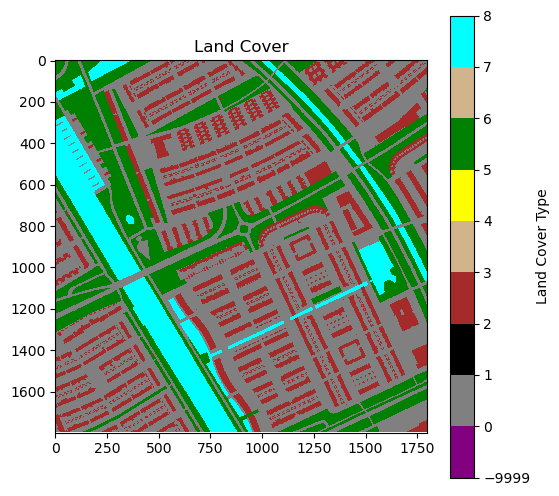

loaded


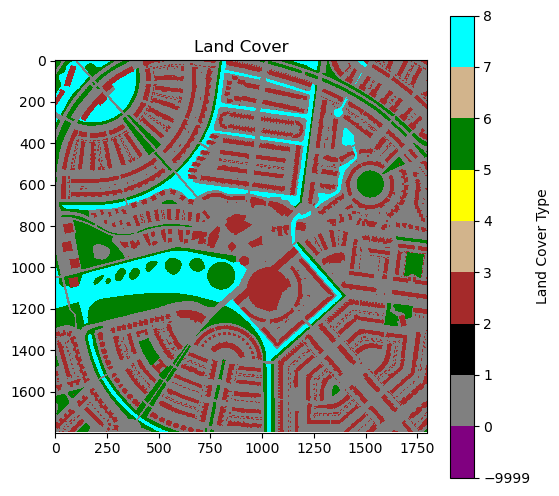

loaded


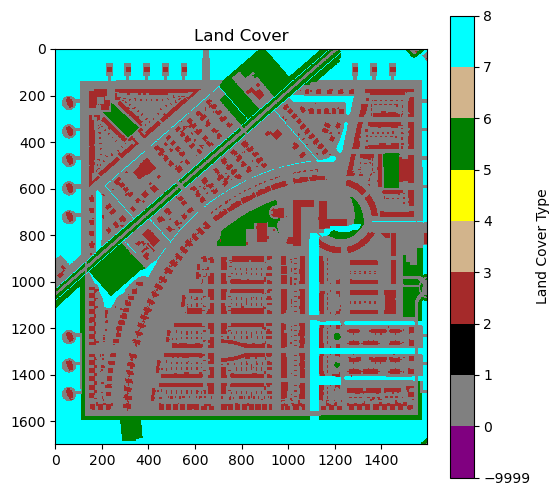

loaded


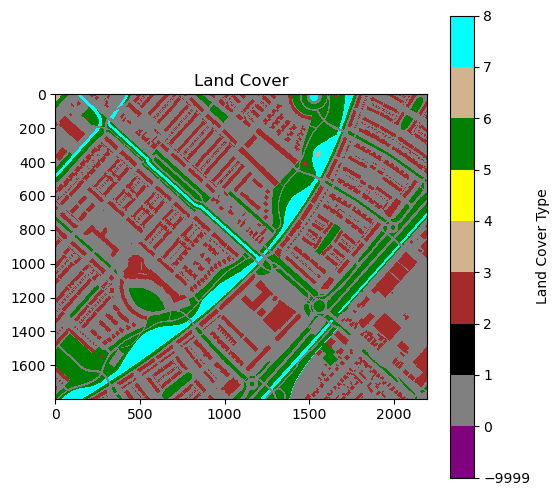

loaded


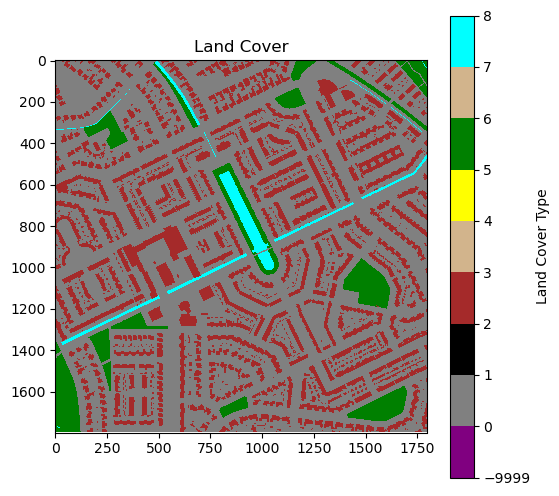

loaded


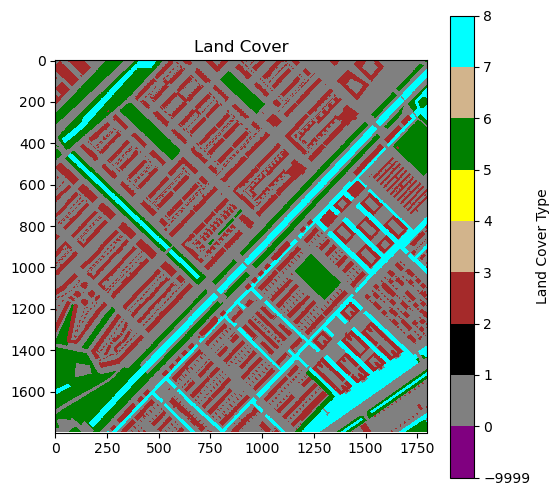

loaded


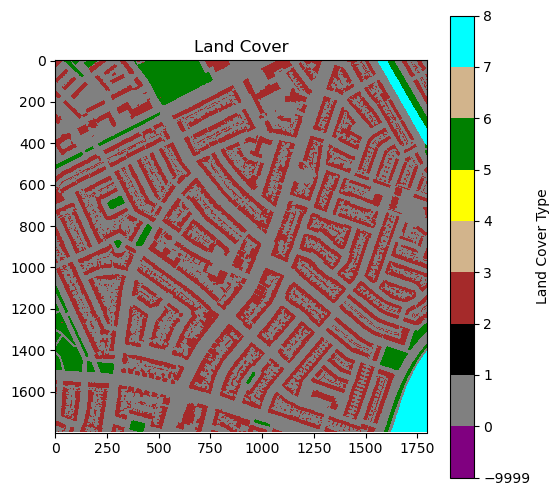

loaded


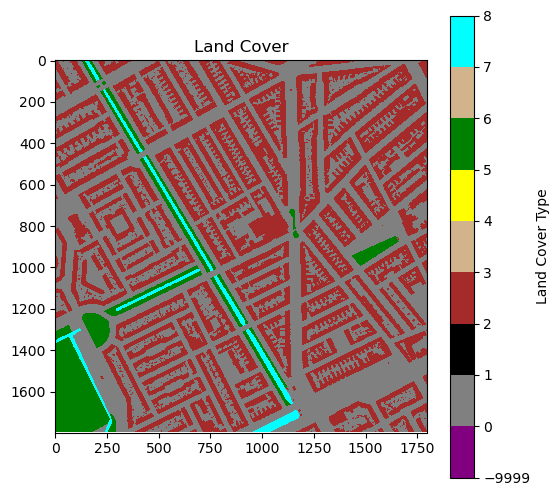

loaded


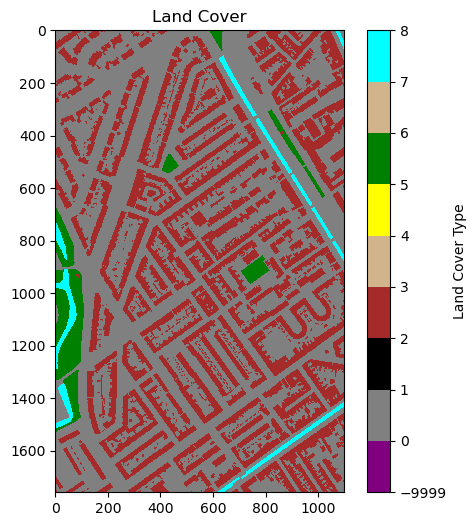

loaded


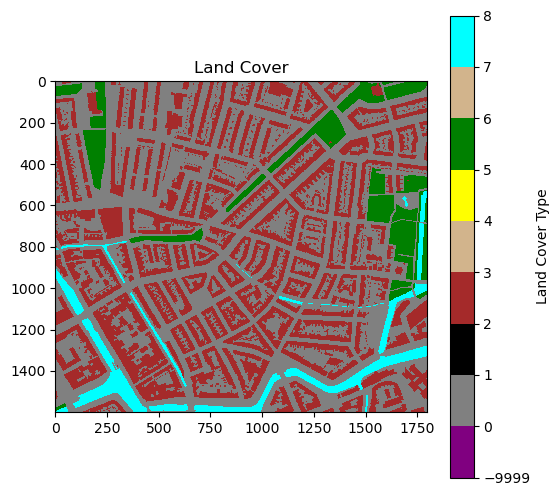

loaded


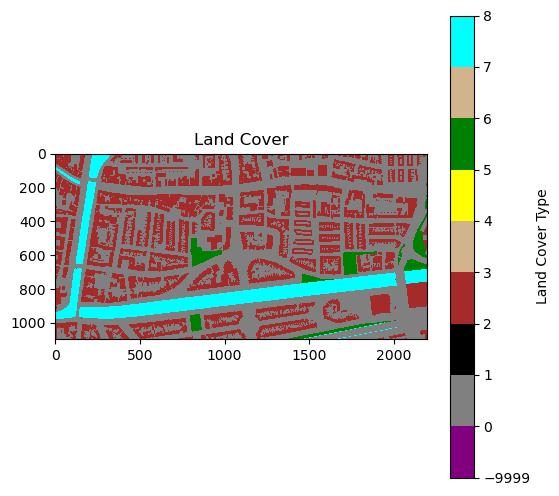

loaded


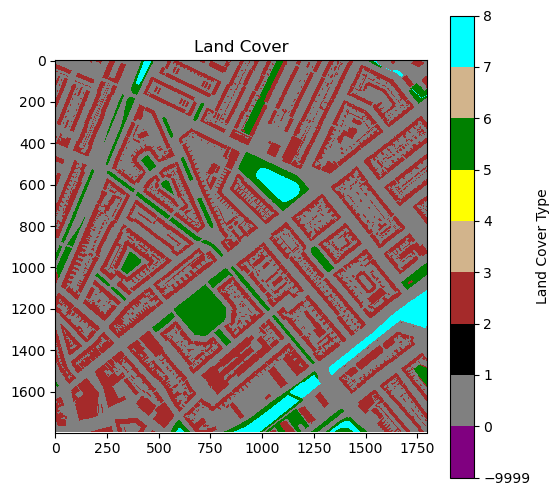

loaded


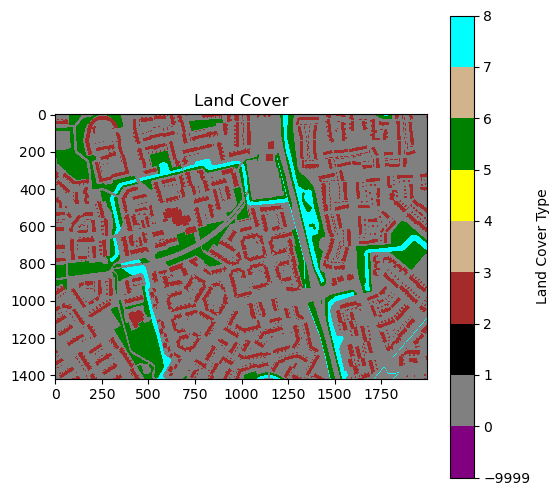

loaded


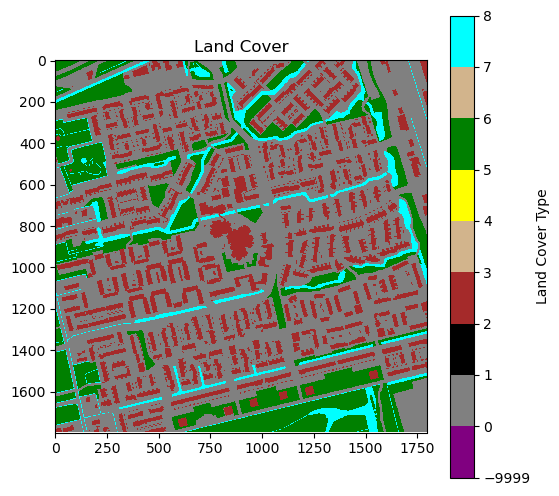

loaded


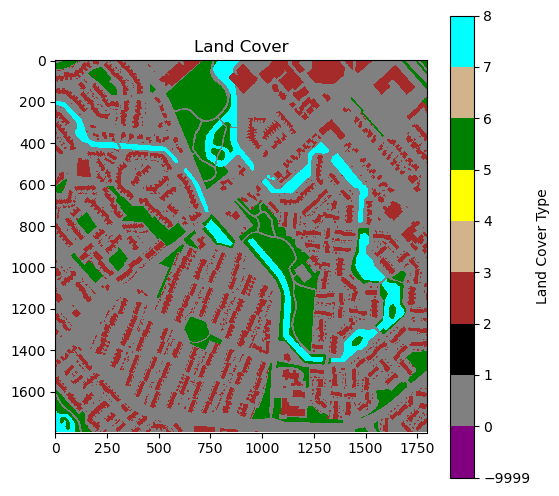

loaded


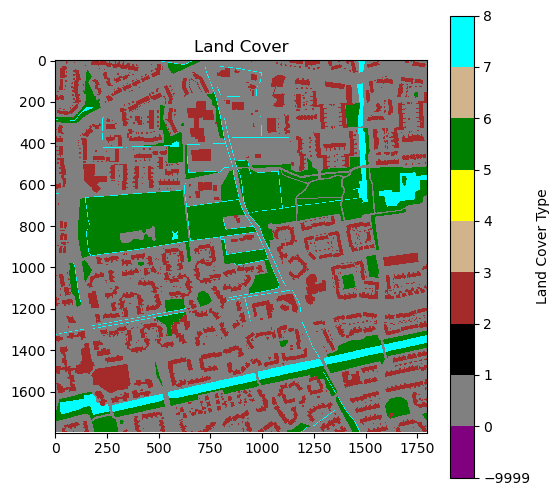

loaded


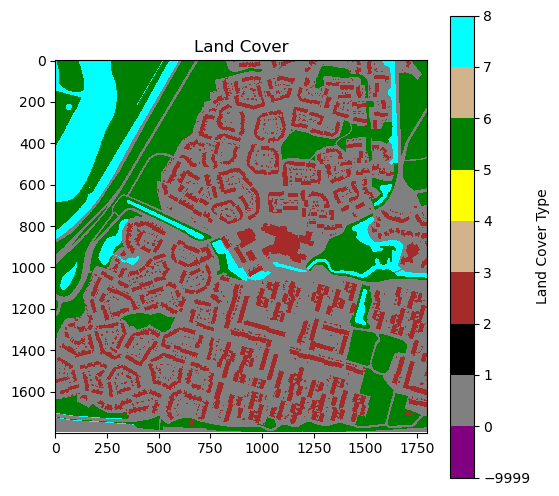

loaded


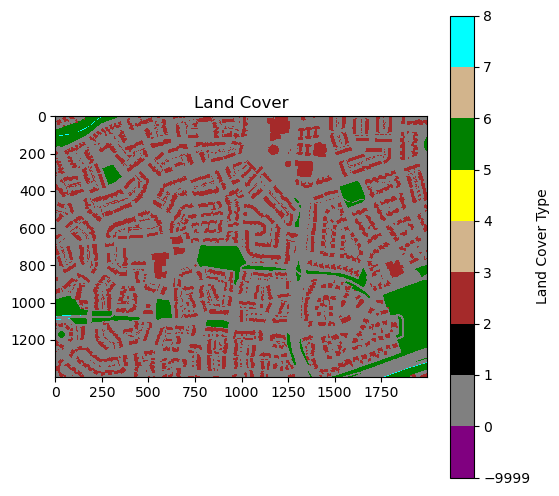

loaded


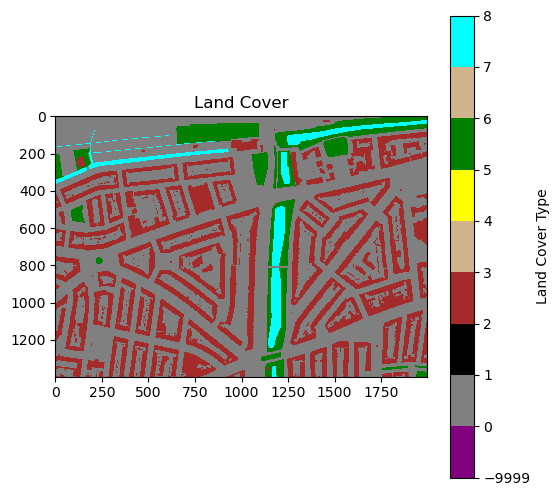

loaded


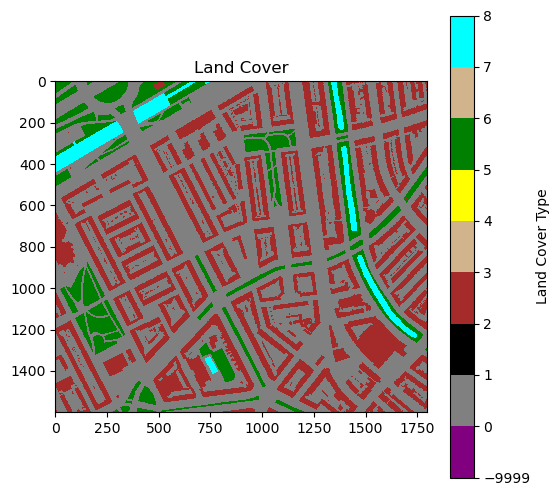

loaded


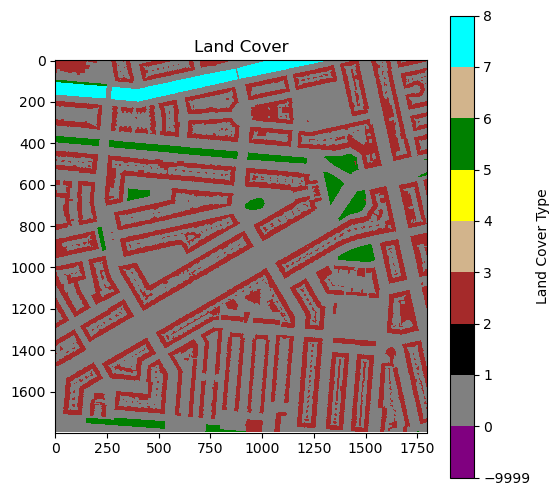

loaded


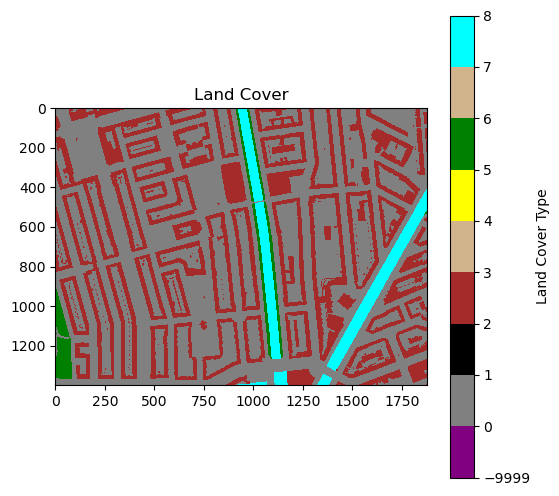

Skipping stedelijk, index 4 – bounding box not found.
Skipping stedelijk, index 5 – bounding box not found.


In [28]:
base_folder = "D:/Geomatics/thesis/_analysisfinalfurther/"
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']
locs = [0, 1, 2, 3, 4, 5]
sol = 'solweig_ext'

for typ in typologies:
    typology_path = os.path.join(base_folder, typ)
    for i in locs:
        try:
            boundingbox = bbox_dict[typ][i]
        except (KeyError, IndexError):
            print(f"Skipping {typ}, index {i} – bounding box not found.")
            continue

        dtm_path = typology_path + f"/loc_{i}/final_dtm.tif"

        buildingslocation = Buildings(boundingbox)


        landcover = LandCover(boundingbox, dataset_path=dtm_path, building_data=buildingslocation.building_geometries)

        building_mask = ~landcover.building_mask
        water_mask = landcover.water_mask

        if water_mask is not None:
            total_mask = np.logical_or(building_mask, ~water_mask).astype(np.uint8)
        else:
            total_mask = building_mask.astype(np.uint8)

        dataset = gdal.Open(dtm_path)
        saveraster(dataset, typology_path + f'/loc_{i}/masks.tif', total_mask)

In [ ]:
base_folder = "D:/Geomatics/thesis/_analysisfinalfurther/"
typologies = ['historisch', 'tuindorp', 'vinex', 'volkswijk', 'bloemkool', 'stedelijk']
locs = [0, 1, 2, 3, 4, 5]
sol = 'solweig_ext'

# Store Tmrt stats per typology and time group
typology_tmrt_stats = defaultdict(lambda: defaultdict(list))


for typ in typologies:
    typology_path = os.path.join(base_folder, typ)

    for i in locs:
        boundingbox = bbox_dict[typ][i]
        area_path = typology_path + f"loc_{i}/{sol}/"

        landcover = LandCover(boundingbox)


        building_mask = landcover.building_mask
        water_mask_path = landcover.water_mask

        building_mask = load_mask(building_mask_path)
        water_mask = load_mask(water_mask_path)

        # Initialize TmrtOutput
        tmrt_processor = TmrtOutput(output_folder=area_path, building_mask=building_mask, water_mask=water_mask)

        # Morning, afternoon, evening averages
        for time_group, avg_array in tmrt_processor.averaged_tmrt.items():
            if avg_array is not None:
                stats = tmrt_processor.calculate_stats_and_bins(avg_array, isTmrt=True)
                typology_tmrt_stats[typ][time_group].append(stats)

        # Extract and process 12:00 data
        tmrt_12 = tmrt_processor.tmrt_arrays_by_time.get("1200")
        if tmrt_12 is not None:
            stats_12 = tmrt_processor.calculate_stats_and_bins(tmrt_12, isTmrt=True)
            typology_tmrt_stats[typ]["1200"].append(stats_12)